In [61]:

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

#To ensure you have only the correct device visible:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16293877403044018344
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 347078656
locality {
  bus_id: 1
}
incarnation: 10399452816420523540
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:09:00.0"
]


In [62]:
import pandas as pd
import numpy as np

data = pd.read_csv('mergedChEMBLDF.csv')

/ihome/gidakwo/anaconda3/envs/ml_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,29,31,33,35,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
data.head()

,stdInChiKey,1613933_operator,1613933_value,1614063_operator,1614063_value,1614364_operator,1614364_value,1614421_operator,1614421_value,1794557_operator,...,3705123_operator,3705123_value,3705362_operator,3705362_value,3705488_operator,3705488_value,3706373_operator,3706373_value,smiles,smiles_parent
0,RJYFVJPEXKPGNZ-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,=,1412.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1ccccc1C2CCN(CC2)C(=Nc3ccc(Br)cc3)S,COc1ccccc1C1CCN(C(S)=Nc2ccc(Br)cc2)CC1
1,GNWGGHKGEXNNMK-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,=,17782.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ccc(O)c(NC(=O)c2onc(c2)c3ccc(F)cc3)c1,Cc1ccc(O)c(NC(=O)c2cc(-c3ccc(F)cc3)no2)c1
2,LVDHDRPSCLIFHH-RDRPBHBLSA-N,NaN,NaN,NaN,NaN,=,5011.9,=,10000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1ccccc1NC(=O)C(=O)N\N=C(/C)\CC(=O)Nc2ccc(OC...,COc1ccccc1NC(=O)C(=O)NN=C(C)CC(=O)Nc1ccc(OCc2c...
3,OJENVBWGZAMKEC-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,=,707.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC(=O)c1ccc(NC(=O)c2oc(cc2)c3ccc(Cl)cc3)cc1,CC(=O)c1ccc(NC(=O)c2ccc(-c3ccc(Cl)cc3)o2)cc1
4,HGUWAIXVEMNODZ-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,=,19952.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1nc2ncnn2c(N3CCN(CC3)c4cccc(c4)C(F)(F)F)c1C,Cc1nc2ncnn2c(N2CCN(c3cccc(C(F)(F)F)c3)CC2)c1C


In [64]:
assays = [2218781, 2328568, 3705123, 3705362, 3705488, 3706373]
#1613933, 1614063, 1614364, 1614421, 1794557 = Evaluate_Chembl_RNN
#1909116, 1909123, 1909130, 1909184, 1909186, 1909187, 1909194, 1909195, 1909196 = Unspecified value (fails)

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def chembl_test(data, assay):
    print('Working on Assay ID: %s...' %(assay))
    df = data[['smiles_parent', str(assay) +'_value']]
    df = df[df[str(assay) +'_value' ].notnull()]
    #df = df[pd.to_numeric(df[str(assay) +'_value'], errors='coerce').notnull()] #eliminate rows with non-numeric values
    
    X = df['smiles_parent'].reset_index(drop=True)
    y =  df[str(assay) +'_value' ].reset_index(drop=True)

    from sklearn.model_selection import train_test_split


    X_train,  X_test, y_train, y_test = train_test_split(X, np.log(y).values.reshape(-1,1), random_state=42)

    dd = np.column_stack((X_train,y_train))
    dd = np.random.permutation(np.repeat(dd, 10, axis=0)) #Duplicate each sample 10 times, then shuffle
    X_train = dd[:,0]
    y_train = dd[:,1].reshape(-1,1)
    
    
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)

    y_train = rbs.fit_transform((y_train))
    y_test = rbs.transform(y_test)
    plt.figure()
    plt.hist(y_train, bins=25)
    plt.title("Assay %s train distribution"%(assay))
    plt.savefig("Images/%s_distribution.png"%(assay))
    plt.show()
    
    import keras.backend as K
    from SmilesEnumerator import SmilesIterator
    from SmilesEnumerator import SmilesEnumerator
    sme = SmilesEnumerator()
    #The SmilesEnumerator must be fit to the entire dataset, so that all chars are registered
    sme.fit(X, extra_chars="56790%", extra_pad=10)
    sme.leftpad = True
    
    batch_size = 64
    #The dtype is set for the K.floatx(), which is the numerical type configured for Tensorflow or Theano
    generator = SmilesIterator(X_train, y_train, sme, batch_size = batch_size, dtype=K.floatx())
    val_generator = SmilesIterator(X_test, y_test, sme, batch_size = batch_size, dtype=K.floatx())
    
    X_,y_ = generator.next()
    #print(X_.shape)
    #print(y_.shape)
    #--------------------------------------------------------
    input_shape = X_.shape[1:]
    output_shape = 1

    #Build a SMILES based RNN QSAR model with Keras.
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    from keras.layers.core import Dropout
    from keras.callbacks import ReduceLROnPlateau
    from keras import regularizers
    from keras.optimizers import RMSprop, Adam

    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, return_sequences=False #dropout = 0.19, unroll= True 
                  ))

    #model.add(LSTM(16, dropout = 0.1, return_sequences=False)) 

    model.add(Dense(output_shape,
                    #kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                    activation="linear"))

    model.compile(loss="mse", optimizer=RMSprop(lr=0.005))
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=50, min_lr=0.00001, verbose=1)

    history = model.fit_generator(generator, validation_data = val_generator, validation_steps=len(X_test)/batch_size,
                                  steps_per_epoch=len(X_train)/batch_size, 
                                  epochs=500, verbose = 0,
                                  callbacks=[reduce_lr])

    plt.figure()
    y_pred_train = model.predict(sme.transform(X_train))
    y_pred_test = model.predict(sme.transform(X_test))
    plt.scatter(y_train, y_pred_train, label="Train")
    plt.scatter(y_test, y_pred_test, label="Test")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title("Assay %s Performance" %(assay))
    plt.legend()
    plt.savefig("Images/%s_performance.png"%(assay))
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Test")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title("Assay %s Learning Curve"%(assay))
    plt.legend()
    plt.savefig("Images/%s_learning.png"%(assay))
    plt.show()
    print('-----------------------------------------------------------')

Working on Assay ID: 2218781...


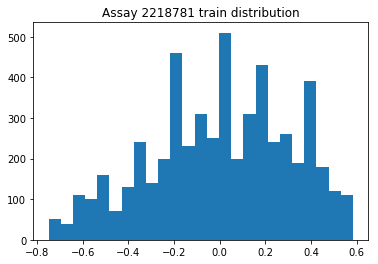

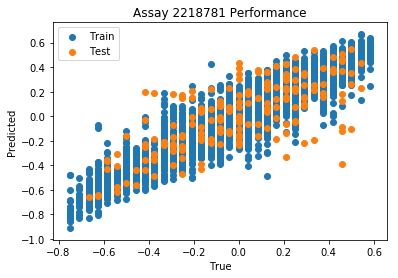

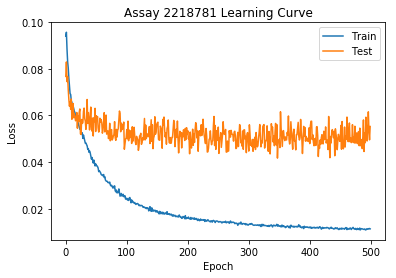

-----------------------------------------------------------
Working on Assay ID: 2328568...


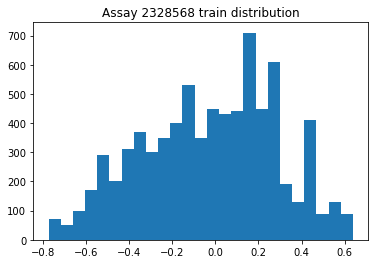


Epoch 00367: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00500: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


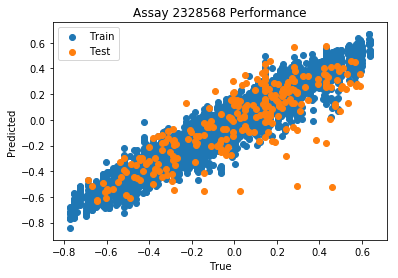

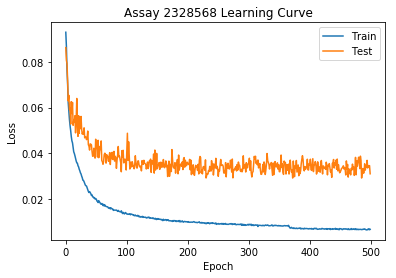

-----------------------------------------------------------
Working on Assay ID: 3705123...


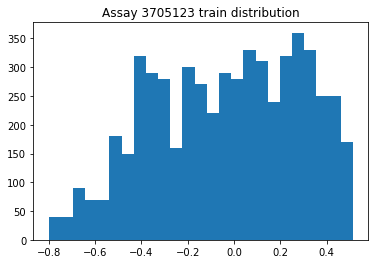

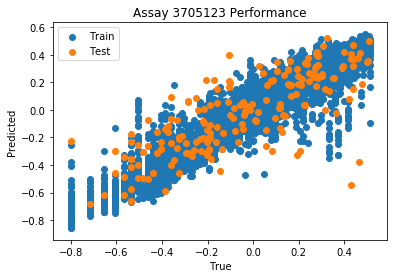

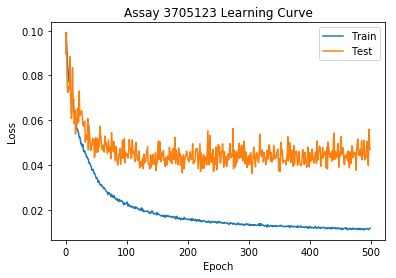

-----------------------------------------------------------
Working on Assay ID: 3705362...


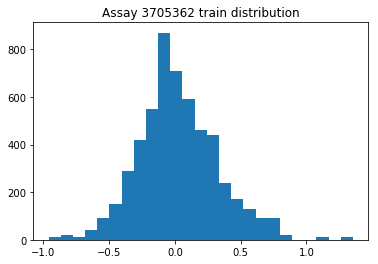

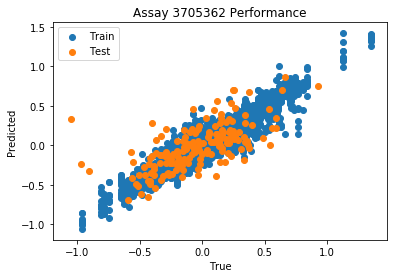

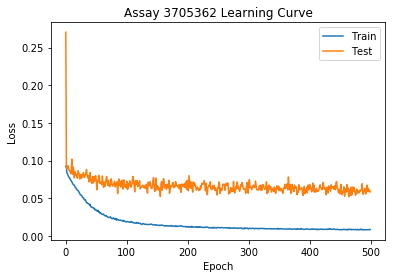

-----------------------------------------------------------
Working on Assay ID: 3705488...


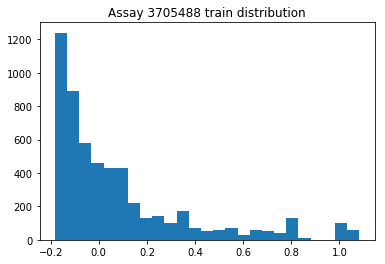

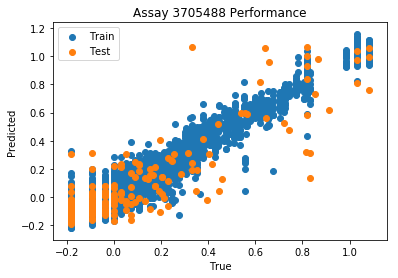

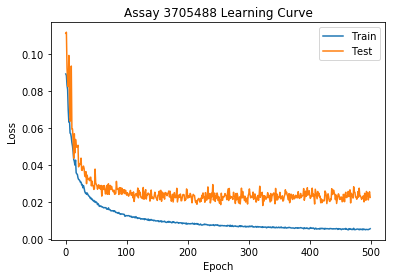

-----------------------------------------------------------
Working on Assay ID: 3706373...


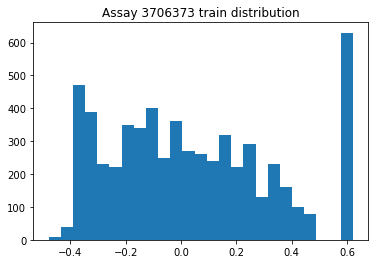


Epoch 00500: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.


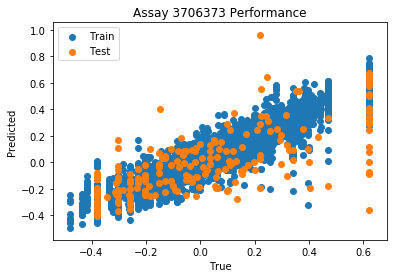

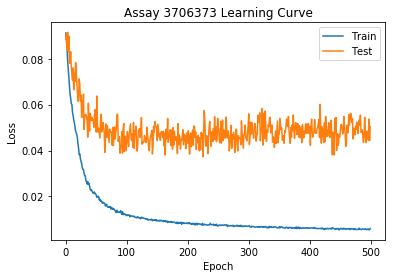

-----------------------------------------------------------


In [67]:
for assay in assays:
    chembl_test(data, assay)